In [7]:
# !pip install openvino

! pip install openvino-dev -q 

# Text Spotting with OpenVINO™

This notebook demonstrates text spotting (simultaneous detection and recognition) with OpenVINO, using the [Text Spotting Model](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/text-spotting-0005/README.md) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/). The model is built on top of the Mask-RCNN framework with additional attention-based text recognition head.

### What is Text Spotting ?
Text spotting in deep learning refers to the task of detecting and recognizing text in images or videos. It is a computer vision problem that has a wide range of applications, such as scene text recognition, document analysis, and optical character recognition (OCR).This model is a Mask-RCNN-based text detector with ResNet50 backbone and additional text features output.
The  notebook shows how to create the following pipeline:

### Test Data Source
Example image data comes from [Total-Text-Dataset](https://github.com/cs-chan/Total-Text-Dataset)

## Imports

All the necessary libraries are imported.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.special import softmax
from openvino.runtime import Core

## Downloading Models

Models are downloaded from [Open-Model-Zoo](https://github.com/openvinotoolkit/open_model_zoo) using the `omz_downloader` tool, which was installed with the `openvino-dev` at the top cell.

In [2]:
# A directory where the model will be downloaded.
base_model_dir = "model"

# The name of the model from Open Model Zoo.
model_name = "text-spotting-0005"

# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16"

# It will be retrieved from the cache if the model is already downloaded.
download_command = (
    f"omz_downloader "
    f"--name {model_name} "
    f"--precision {precision} "
    f"--output_dir {base_model_dir} "
    f"--cache_dir {base_model_dir}"
)

# This code is provided for the first download of the model.
! $download_command

################|| Downloading text-spotting-0005-detector ||################

========== Downloading model/intel/text-spotting-0005/text-spotting-0005-detector/FP16/text-spotting-0005-detector.xml
... 100%, 777 KB, 1116 KB/s, 0 seconds passed

========== Downloading model/intel/text-spotting-0005/text-spotting-0005-detector/FP16/text-spotting-0005-detector.bin
... 100%, 50682 KB, 1160 KB/s, 43 seconds passed

################|| Downloading text-spotting-0005-recognizer-encoder ||################

========== Downloading model/intel/text-spotting-0005/text-spotting-0005-recognizer-encoder/FP16/text-spotting-0005-recognizer-encoder.xml
... 100%, 11 KB, 1956 KB/s, 0 seconds passed

========== Downloading model/intel/text-spotting-0005/text-spotting-0005-recognizer-encoder/FP16/text-spotting-0005-recognizer-encoder.bin
... 100%, 2593 KB, 1117 KB/s, 2 seconds passed

################|| Downloading text-spotting-0005-recognizer-decoder ||################

========== Downloading model/intel/t

We have 3 models.
*  `text-spotting-0005-detector` : this is a pretrained Mask-R-CNN model, to extract different features, from the image.
*  `text-spotting-0005-recognizer-encoder` : This model encodes the features extracted by the previous  model.
* `text-spotting-0005-recognizer-decoder` : This model decodes the encoded information todetected text, and its position.


Now, we will load those models from downloaded `.xml` and `.bin` files.

In [3]:
# Initialize OpenVINO Runtime
core = Core()

# Loading the networks and corresponding weights from a file.

# Detector Model
detector_model = "text-spotting-0005-detector"
detector_model_path = f"model/intel/{model_name}/{detector_model}/{precision}/{detector_model}.xml"
mask_rcnn_model = core.read_model(model=detector_model_path)

# Encoder Model
encoder_model = "text-spotting-0005-recognizer-encoder"
encoder_model_path = f"model/intel/{model_name}/{encoder_model}/{precision}/{encoder_model}.xml"
text_enc_model = core.read_model(model=encoder_model_path)

# Decoder Model
decoder_model = "text-spotting-0005-recognizer-decoder"
decoder_model_path = f"model/intel/{model_name}/{decoder_model}/{precision}/{decoder_model}.xml"
text_dec_model = core.read_model(model=decoder_model_path)

Here, we compile the models, and prepare them for inference.

In [4]:
# Compiling models and preparing for inference

# Detector Model
mask_rcnn_compiled_model = core.compile_model(mask_rcnn_model, device_name='CPU')
mask_rcnn_infer_request = mask_rcnn_compiled_model.create_infer_request()

# Encoder Model
text_enc_compiled_model = core.compile_model(text_enc_model, 'CPU')
text_enc_output_tensor = text_enc_compiled_model.outputs[0]
text_enc_infer_request = text_enc_compiled_model.create_infer_request()

# Decoder Model
text_dec_compiled_model = core.compile_model(text_dec_model, 'CPU')
text_dec_infer_request = text_dec_compiled_model.create_infer_request()

hidden_shape = text_dec_model.input('prev_hidden').shape
text_dec_output_names = {'output','hidden'}

In this demo, we are using only a single image each time.

In [5]:
input_tensor_name = 'image'

try:
    # extracting the model input shape
    n, c, h, w = mask_rcnn_model.input(input_tensor_name).shape
    if (n != 1):
        raise RuntimeError('Only batch 1 is supported by the demo application')
except RuntimeError:
    raise RuntimeError('Demo supports only topologies with the following input tensor name: {}'.format(input_tensor_name))

Lets check if all expected output features are available.

In [6]:
required_output_names = {'boxes', 'labels', 'masks', 'text_features'}
for output_tensor_name in required_output_names:
    try:
        mask_rcnn_model.output(output_tensor_name)
        
    except RuntimeError:
        raise RuntimeError('Demo supports only topologies with the following  output tensor names: {}'.format(', '.join(required_output_names)))

These are some utility functions for the later stage.

In [8]:
# These are collected from the official python demo (Open Model Zoo).
# https://github.com/openvinotoolkit/open_model_zoo/blob/02a599f8140bede79cdfe24904c32240b929dacb/demos/text_spotting_demo/python/text_spotting_demo.py

def expand_box(box, scale):
    """
        Expands the given bounding box by the specified scale factor.
        
        Parameters:
            box (numpy.ndarray): 
                The bounding box to be expanded, represented as a 1-D numpy array with 4 elements (x_min, y_min, x_max, y_max).
            scale (float): 
                The scale factor to expand the bounding box by.
        
        Returns(numpy.ndarray):
                The expanded bounding box, represented as a 1-D numpy array with 4 elements (x_min, y_min, x_max, y_max).
    """
    w_half = (box[2] - box[0]) * .5
    h_half = (box[3] - box[1]) * .5
    x_c = (box[2] + box[0]) * .5
    y_c = (box[3] + box[1]) * .5
    w_half *= scale
    h_half *= scale
    box_exp = np.zeros(box.shape)
    box_exp[0] = x_c - w_half
    box_exp[2] = x_c + w_half
    box_exp[1] = y_c - h_half
    box_exp[3] = y_c + h_half
    return box_exp


def segm_postprocess(box, raw_cls_mask, im_h, im_w):
    """
        Helper function to create masks from the segmentation information extrated by Mask-R-CNN detector
        
        Parameters:
           box (np.ndarray): 
                Detected bbox locations
           raw_cls_mask (np.ndarray): 
                Segmentation mask for detected class
           im_h (int): 
                Image Height
           im_w (int): 
                Image Width
        Returns:
            im_mask(np.ndarray):
                    Mask for detected text
    """
    # Add zero border to prevent upsampling artifacts on segment borders.
    raw_cls_mask = np.pad(raw_cls_mask, ((1, 1), (1, 1)), 'constant', constant_values=0)
    extended_box = expand_box(box, raw_cls_mask.shape[0] / (raw_cls_mask.shape[0] - 2.0)).astype(int)
    w, h = np.maximum(extended_box[2:] - extended_box[:2] + 1, 1)
    x0, y0 = np.clip(extended_box[:2], a_min=0, a_max=[im_w, im_h])
    x1, y1 = np.clip(extended_box[2:] + 1, a_min=0, a_max=[im_w, im_h])

    raw_cls_mask = cv2.resize(raw_cls_mask, (w, h)) > 0.5
    mask = raw_cls_mask.astype(np.uint8)
    # Put an object mask in an image mask.
    im_mask = np.zeros((im_h, im_w), dtype=np.uint8)
    im_mask[y0:y1, x0:x1] = mask[(y0 - extended_box[1]):(y1 - extended_box[1]), (x0 - extended_box[0]):(x1 - extended_box[0])]
    return im_mask

These are some more utility f

In [9]:

import random
import colorsys


# Source: https://github.com/openvinotoolkit/open_model_zoo/blob/58028c5a57b99d920ff9a7c1c350d4da1af36bed/demos/common/python/visualizers/drawing_utils.py#L1
class ColorPalette:
    """
        Creates a color pallete for visualization colors.
    """
    def __init__(self, n, rng=None):
        if n == 0:
            raise ValueError('ColorPalette accepts only the positive number of colors')
        if rng is None:
            rng = random.Random(0xACE)  # nosec - disable B311:random check

        candidates_num = 100
        hsv_colors = [(1.0, 1.0, 1.0)]
        for _ in range(1, n):
            colors_candidates = [(rng.random(), rng.uniform(0.8, 1.0), rng.uniform(0.5, 1.0))
                                 for _ in range(candidates_num)]
            min_distances = [self.min_distance(hsv_colors, c) for c in colors_candidates]
            arg_max = np.argmax(min_distances)
            hsv_colors.append(colors_candidates[arg_max])

        self.palette = [self.hsv2rgb(*hsv) for hsv in hsv_colors]

    @staticmethod
    def dist(c1, c2):
        dh = min(abs(c1[0] - c2[0]), 1 - abs(c1[0] - c2[0])) * 2
        ds = abs(c1[1] - c2[1])
        dv = abs(c1[2] - c2[2])
        return dh * dh + ds * ds + dv * dv

    @classmethod
    def min_distance(cls, colors_set, color_candidate):
        distances = [cls.dist(o, color_candidate) for o in colors_set]
        return np.min(distances)

    @staticmethod
    def hsv2rgb(h, s, v):
        return tuple(round(c * 255) for c in colorsys.hsv_to_rgb(h, s, v))

    def __getitem__(self, n):
        return self.palette[n % len(self.palette)]

    def __len__(self):
        return len(self.palette)


# Source: https://github.com/openvinotoolkit/open_model_zoo/blob/58028c5a57b99d920ff9a7c1c350d4da1af36bed/demos/common/python/visualizers/instance_segmentation.py
class InstanceSegmentationVisualizer:
    """
        This class is responsible for overlaying(visualizing) the predicted information on the image.
    """
    def __init__(self, labels=None, show_boxes=False, show_scores=False):
        colors_num = len(labels) if labels else 80
        self.labels = labels
        self.palette = ColorPalette(colors_num)
        self.show_boxes = show_boxes
        self.show_scores = show_scores

    def __call__(self, image, boxes, classes, scores, masks=None, ids=None, texts=None):
        result = image.copy()

        if masks is not None:
            result = self.overlay_masks(result, masks, ids)
        if self.show_boxes:
            result = self.overlay_boxes(result, boxes, classes)

        result = self.overlay_labels(result, boxes, classes, scores, texts)
        return result

    def overlay_masks(self, image, masks, ids=None):
        segments_image = image.copy()
        aggregated_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        aggregated_colored_mask = np.zeros(image.shape, dtype=np.uint8)
        all_contours = []

        for i, mask in enumerate(masks):
            contours = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
            if contours:
                all_contours.append(contours[0])

            mask_color = self.palette[i if ids is None else ids[i]]
            cv2.bitwise_or(aggregated_mask, mask, dst=aggregated_mask)
            cv2.bitwise_or(aggregated_colored_mask, mask_color, dst=aggregated_colored_mask, mask=mask)

        # Fill the area occupied by all instances with a colored instances mask image
        cv2.bitwise_and(segments_image, (0, 0, 0), dst=segments_image, mask=aggregated_mask)
        cv2.bitwise_or(segments_image, aggregated_colored_mask, dst=segments_image, mask=aggregated_mask)

        cv2.addWeighted(image, 0.5, segments_image, 0.5, 0, dst=image)
        cv2.drawContours(image, all_contours, -1, (0, 0, 0))
        return image

    def overlay_boxes(self, image, boxes, classes):
        for box, class_id in zip(boxes, classes):
            color = self.palette[class_id]
            box = box.astype(int)
            top_left, bottom_right = box[:2], box[2:]
            image = cv2.rectangle(image, top_left, bottom_right, color, 2)
        return image

    def overlay_labels(self, image, boxes, classes, scores, texts=None):
        if texts:
            labels = texts
        elif self.labels:
            labels = (self.labels[class_id] for class_id in classes)
        else:
            raise RuntimeError('InstanceSegmentationVisualizer must contain either labels or texts to display')
        template = '{}: {:.2f}' if self.show_scores else '{}'

        for box, score, label in zip(boxes, scores, labels):
            text = template.format(label, score)
            textsize = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
            position = ((box[:2] + box[2:] - textsize) / 2).astype(np.int32)
            cv2.putText(image, text, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
        return image

In [11]:

# Start of Sequence Token
SOS_INDEX = 0

# Start of Sequence Token
EOS_INDEX = 1

# Maximum lenth of sentence
MAX_SEQ_LEN = 28


# Alphabet that is used for decoding.
alphabet = '  abcdefghijklmnopqrstuvwxyz0123456789'

# Probability threshold for detections filtering
prob_threshold = 0.5

# Text recognition confidence threshold
tr_threshold = 0.5


# Maintain the aspect ratio of the input image
keep_aspect_ratio = True

# Name of previous symbol input node to text recognition head decoder part.
trd_input_prev_symbol = 'prev_symbol'

# Name of previous hidden input node to text recognition head decoder part.
trd_input_prev_hidden = 'prev_hidden'

# Name of encoder outputs input node to text recognition head decoder part.
trd_input_encoder_outputs = 'encoder_outputs'

# Name of symbols distribution output node from text recognition head decoder part.
trd_output_symbols_distr = 'output'

# Name of current hidden output node from text recognition head decoder part.
trd_output_cur_hidden = 'hidden'

## Loading the image

In [12]:
# The `image_file` variable can point to a URL or a local image.
image_file = str(Path('..') / 'data' / 'image' / 'totaltext_lookout.jpg')

frame = cv2.imread(image_file)

'../data/image/totaltext_lookout.jpg'

Resize the image if necessary

In [18]:
if not keep_aspect_ratio:
    # Resize the image to a target size.
    scale_x = w / frame.shape[1]
    scale_y = h / frame.shape[0]
    input_image = cv2.resize(frame, (w, h))
else:
    # Resize the image to keep the same aspect ratio and to fit it to a window of a target size.
    scale_x = scale_y = min(h / frame.shape[0], w / frame.shape[1])
    input_image = cv2.resize(frame, None, fx=scale_x, fy=scale_y)

raw_frame = input_image
# Pad theimage to match model input size
input_image_size = input_image.shape[:2]
input_image = np.pad(input_image, ((0, h - input_image_size[0]), (0, w - input_image_size[1]), (0, 0)), mode='constant', constant_values=0)

This model supports images in `CHW` format (Channels first), but the image was read in `HWC`  format (Channels Last) . So we are fixing that.

In [19]:
# Change data layout from HWC to CHW.
input_image = input_image.transpose((2, 0, 1))
input_image = input_image.reshape((n, c, h, w)).astype(np.float32)

## Detector Model Prediction

In [20]:
# Run the MaskRCNN model.
mask_rcnn_infer_request.infer({input_tensor_name: input_image})
outputs = {name: mask_rcnn_infer_request.get_tensor(name).data[:] for name in required_output_names}

# Parse detection results of the current request
boxes = outputs['boxes'][:, :4]
scores = outputs['boxes'][:, 4]
classes = outputs['labels'].astype(np.uint32)
raw_masks = outputs['masks']
text_features = outputs['text_features']

# Filter out detections with low confidence.
detections_filter = scores > prob_threshold
scores = scores[detections_filter]
classes = classes[detections_filter]
boxes = boxes[detections_filter]
raw_masks = raw_masks[detections_filter]
text_features = text_features[detections_filter]

boxes[:, 0::2] /= scale_x
boxes[:, 1::2] /= scale_y
masks = []

# Creates mask using detected text position
for box, cls, raw_mask in zip(boxes, classes, raw_masks):
    mask = segm_postprocess(box, raw_mask, frame.shape[0], frame.shape[1])
    masks.append(mask)

## Encode and Decoder Model Prediction

In [21]:
texts = []
for feature in text_features:

    # Prepare the input for the encoding model
    input_data = {'input': np.expand_dims(feature, axis=0)}
    
    # Encode into useful features for decoder model
    feature = text_enc_infer_request.infer(input_data)[text_enc_output_tensor]
    feature = np.reshape(feature, (feature.shape[0], feature.shape[1], -1))
    feature = np.transpose(feature, (0, 2, 1))

    # Initialize the hidden state and previous symbol index
    hidden = np.zeros(hidden_shape)
    prev_symbol_index = np.ones((1,)) * SOS_INDEX

    text = ''
    text_confidence = 1.0

    # Decode the features from encoder
    for i in range(MAX_SEQ_LEN):

        # Get the next symbol and hidden state
        text_dec_infer_request.infer({
            trd_input_prev_symbol: np.reshape(prev_symbol_index, (1,)),
            trd_input_prev_hidden: hidden,
            trd_input_encoder_outputs: feature})
        decoder_output = {name: text_dec_infer_request.get_tensor(name).data[:] for name in text_dec_output_names}
        symbols_distr = decoder_output[trd_output_symbols_distr]
        
        # Compute the softmax of the symbol distribution
        symbols_distr_softmaxed = softmax(symbols_distr, axis=1)[0]
        
        # Get the next symbol
        prev_symbol_index = int(np.argmax(symbols_distr, axis=1))
        
        # Update the text confidence
        text_confidence *= symbols_distr_softmaxed[prev_symbol_index]
        
        # Check if we have reached the end of the sequence
        if prev_symbol_index == EOS_INDEX:
            break
        
        # Update the text
        text += alphabet[prev_symbol_index]

        # Update the hidden state
        hidden = decoder_output[trd_output_cur_hidden]

    # Append the text to the list of texts
    texts.append(text if text_confidence >= tr_threshold else '')

In [22]:
# Detected text and confidence score
for t, s in zip(texts, scores):
    print(f'{t }:{s}')

the:0.9936979413032532
peak:0.9929602742195129
lookout:0.9860458970069885


In [23]:
# Track IDs mainly for tracking from frame-to-framr in videos
masks_tracks_ids = None

# Overlay masks, labels and scores on the image
visualizer = InstanceSegmentationVisualizer(show_boxes=True, show_scores=True)
frame = visualizer(frame, boxes, classes, scores, masks, masks_tracks_ids, texts)

## Save and visualize the Result

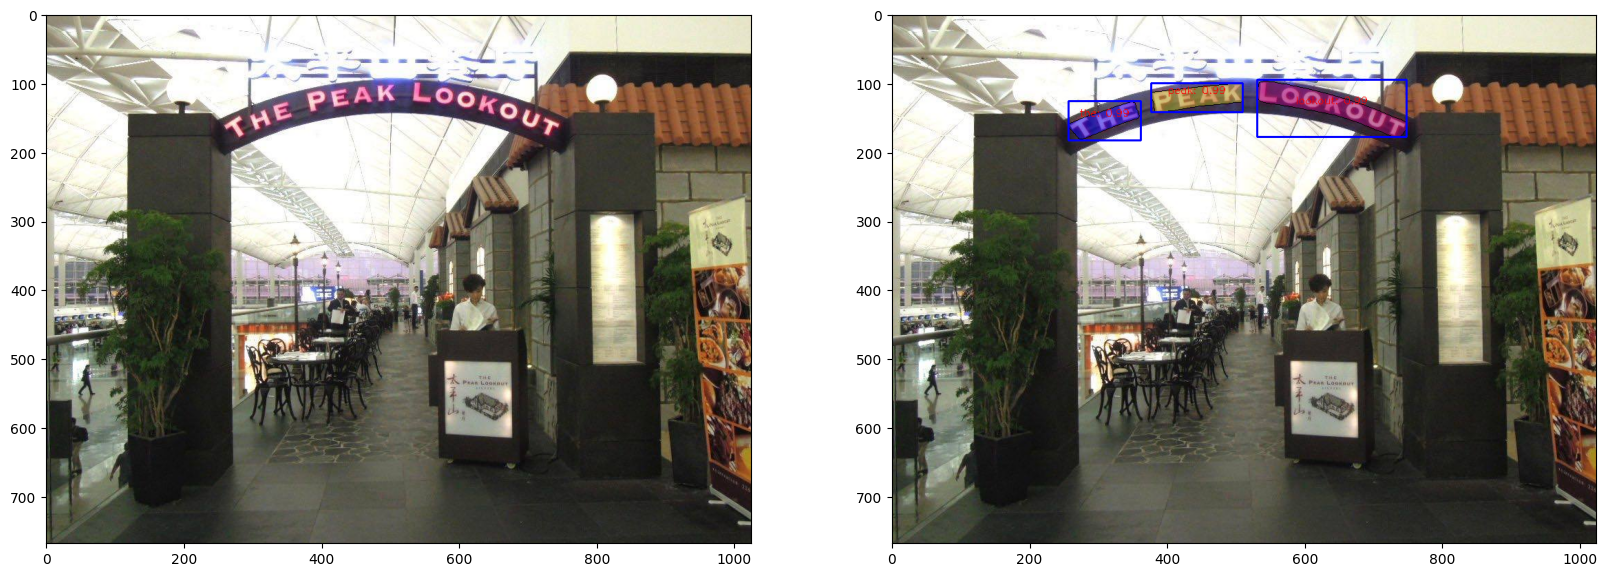

In [24]:
# Saving the image
cv2.imwrite('text-spotted.jpg', frame)

# Visualizing the result
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(raw_frame[:, :, ::-1])
ax[1].imshow(frame[:, :, ::-1])